In [2]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import os
import ast

from api_handling import api_handling
# from Song_Consolidation import Song_Consolidation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from scipy.spatial.distance import cdist

import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
with open('training_2.pickle', 'rb') as f:
    training_data = pickle.load(f)
training_data = training_data[1]

In [5]:
def re_order_features(data):
    for song in range(len(data)):
        list_reordered = []
        list_reordered.append(data[song][6])
        for feature in range(len(data[song][0:6])):
            list_reordered.append(data[song][feature])
        list_reordered.append(data[song][7])
        assert len(list_reordered) == 8, 'fix your code'
        data[song] = list_reordered
    return data

In [6]:
training_data = re_order_features(training_data)

In [35]:
with open('padded_training_data.pickle', 'wb') as f:
    pickle.dump(training_data, f)

### New Index Reference 
- training_data[n] selects song at index n 
- Training_data[n][indicies below represent the following datapoints]
- index 0: 'loudness / segments' loudness level
- index 1: 'beats' start binary
- index 2: 'beats' duration binary
- index 3: 'tatums' start binary
- index 4: 'tatums' duration binary
- index 5: 'bars' start binary
- index 6: 'bars' duration binary
- index 7: 'sections' start binary

- This was necessary to simplify an activation function used in the final layer of my discriminator

In [7]:
def pad_data(data, max_song_length):
    output = data
    for song_index in range(len(output)):
        output[song_index] = pad_sequences(output[song_index], maxlen=max_song_length,truncating='post',padding='post')
    return output

In [8]:
len(training_data[0])

8

In [9]:
training_data = np.array(pad_data(training_data,3000))

In [10]:
training_data = tf.reshape(training_data, (-1, 8, 3000, 1))

In [11]:
def build_discriminator():
    model = Sequential(name='Discriminator')
    model.add(Conv2D(3, 3, input_shape = (8,3000,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(2, 2))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(0.2))

    model.add(MaxPooling2D(pool_size=(1, 15), strides=(1, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Dense(128)) 
    model.add(LeakyReLU(0.2))

    model.add(Dense(64)) 
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))

    model.add(Dense(128)) 
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))

    model.add(Flatten())
    # model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [12]:
discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 2998, 3)        30        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6, 2998, 3)        0         
                                                                 
 dropout (Dropout)           (None, 6, 2998, 3)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 2997, 2)        26        
                                                                 
 dropout_1 (Dropout)         (None, 5, 2997, 2)        0         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5, 2997, 2)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 1499, 2)     

In [13]:
def threshold_and_binarize_func(x):
    # Split the input tensor into the first slice and the remaining slices
    first_slice = x[:, 0, :, :]
    remaining_slices = x[:, 1:, :, :]
    # Threshold the first slice
    thresholded_first_slice = tf.where(first_slice < 0.0, first_slice, 0.0)
    # Binarize the remaining slices
    binarized_remaining_slices = tf.where(remaining_slices < 0.5, 0.0, 1.0)
    # Reshape thresholded_first_slice from (None, 3000, 1) to (None, 1, 3000, 1)
    thresholded_first_slice = tf.reshape(thresholded_first_slice, (-1, 1, 3000, 1))
    # Concatenate the thresholded first slice with the binarized remaining slices
    return tf.concat([thresholded_first_slice, binarized_remaining_slices], axis=1)

In [14]:
def build_generator_2():
    model = Sequential(name='Generator')

    model.add(Dense(800, input_dim=800,name='Dense_1'))  
    model.add(Reshape([8,100,1]))

    model.add(Dense(100, name='Dense_2'))

    model.add(Dense(150, name='Dense_3'))
    model.add(Reshape([8,3000,5]))

    model.add(Dense(100, name='Dense_5'))    
    model.add(LeakyReLU(0.2))

    model.add(Dense(150, name='Dense_6'))    
    model.add(LeakyReLU(0.2))

    model.add(Dense(200, name='Dense_7'))    
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, (1, 1), activation=threshold_and_binarize_func, name='final_layer'))

    return model

In [15]:
def build_generator_3():
    model = Sequential(name='Generator')

    model.add(Dense(3200, input_dim=800, name='Dense_1'))  
    model.add(Reshape([8,400,1]))

    model.add(Conv2D(64, (3, 3), padding='same', name='Conv2D_1'))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), padding='same', name='Conv2D_2'))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), padding='same', name='Conv2D_3'))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(512, (3, 3), padding='same', name='Conv2D_4'))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(1, (1, 1), activation=threshold_and_binarize_func, name='final_layer'))

    return model


In [16]:
def build_generator_4():
    model = Sequential(name='Generator')

    model.add(Dense(1600, input_dim=800,name='Dense_1'))  
    model.add(Reshape([8,100,2]))

    model.add(Dense(100, name='Dense_2'))

    model.add(Dense(150, name='Dense_3'))
    model.add(Reshape([8,3000,5]))

    model.add(Dense(100, name='Dense_5'))    
    model.add(LeakyReLU(0.2))

    model.add(Dense(150, name='Dense_6'))    
    model.add(LeakyReLU(0.2))

    model.add(Dense(200, name='Dense_7'))    
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, (1, 1), activation=threshold_and_binarize_func, name='final_layer'))

    return model

In [17]:
generator = build_generator_4()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 1600)              1281600   
                                                                 
 reshape (Reshape)           (None, 8, 100, 2)         0         
                                                                 
 Dense_2 (Dense)             (None, 8, 100, 100)       300       
                                                                 
 Dense_3 (Dense)             (None, 8, 100, 150)       15150     
                                                                 
 reshape_1 (Reshape)         (None, 8, 3000, 5)        0         
                                                                 
 Dense_5 (Dense)             (None, 8, 3000, 100)      600       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 3000, 100)      0 

In [18]:
class GAN(Model):
    def __init__(self, generator, discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss, *args,**kwargs):
        super().compile(*args, **kwargs)

        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss 

    def train_step(self, truth_batch):
        fake_songs = self.generator(tf.random.normal((40, 800, 1)), training=False)

                # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake songs to the discriminator model
            yhat_real = self.discriminator(truth_batch, training=True) 
            yhat_fake = self.discriminator(fake_songs, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fake songs
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BCE 
            total_disc_loss = self.discriminator_loss(y_realfake, yhat_realfake)


        dgrad = d_tape.gradient(total_disc_loss, self.discriminator.trainable_variables) 
        self.discriminator_optimizer.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))


                # Train the generator 
        with tf.GradientTape() as g_tape: 
            gen_songs = self.generator(tf.random.normal((40,800,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_songs, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_gen_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels) 


                    # Apply backprop
        ggrad = g_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"discriminator_loss":total_disc_loss, "generator_loss":total_gen_loss}

In [19]:
class ModelMonitor(Callback):
    def __init__(self, num_songs=3, latent_dim=800):
        self.num_songs = num_songs
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_songs, self.latent_dim,1))
        generated_songs = self.model.generator(random_latent_vectors)
        data = generated_songs.numpy().tolist()
        with open(os.path.join('../Data/Song_Outputs', f'generated_songs_{epoch}.json'), "w") as file:
            json.dump(data, file)


In [21]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
song_gan = GAN(generator, discriminator)
song_gan.compile(g_opt,d_opt,g_loss,d_loss)

In [22]:
song_gan.fit(training_data, epochs=100, callbacks=[ModelMonitor()],batch_size=40,verbose=1)

Epoch 1/100
173/173 [==============================] - 62s 332ms/step - discriminator_loss: 0.4214 - generator_loss: 1.0238
Epoch 2/100
173/173 [==============================] - 57s 332ms/step - discriminator_loss: 0.3439 - generator_loss: 1.3907
Epoch 3/100
173/173 [==============================] - 57s 331ms/step - discriminator_loss: 0.2983 - generator_loss: 1.7199
Epoch 4/100
173/173 [==============================] - 57s 331ms/step - discriminator_loss: 0.3090 - generator_loss: 1.6896
Epoch 5/100
173/173 [==============================] - 57s 332ms/step - discriminator_loss: 0.2995 - generator_loss: 1.6118
Epoch 6/100
173/173 [==============================] - 57s 332ms/step - discriminator_loss: 0.2942 - generator_loss: 1.5073
Epoch 7/100
173/173 [==============================] - 57s 332ms/step - discriminator_loss: 0.2845 - generator_loss: 1.4652
Epoch 8/100
173/173 [==============================] - 58s 332ms/step - discriminator_loss: 0.2784 - generator_loss: 1.4234
Epoch 9/

In [23]:
generator.save('./Models/generator.h5')
discriminator.save('./Models/discriminator.h5')

In [27]:
song_gan.save_weights('../Models/song_gan_weights.h5')

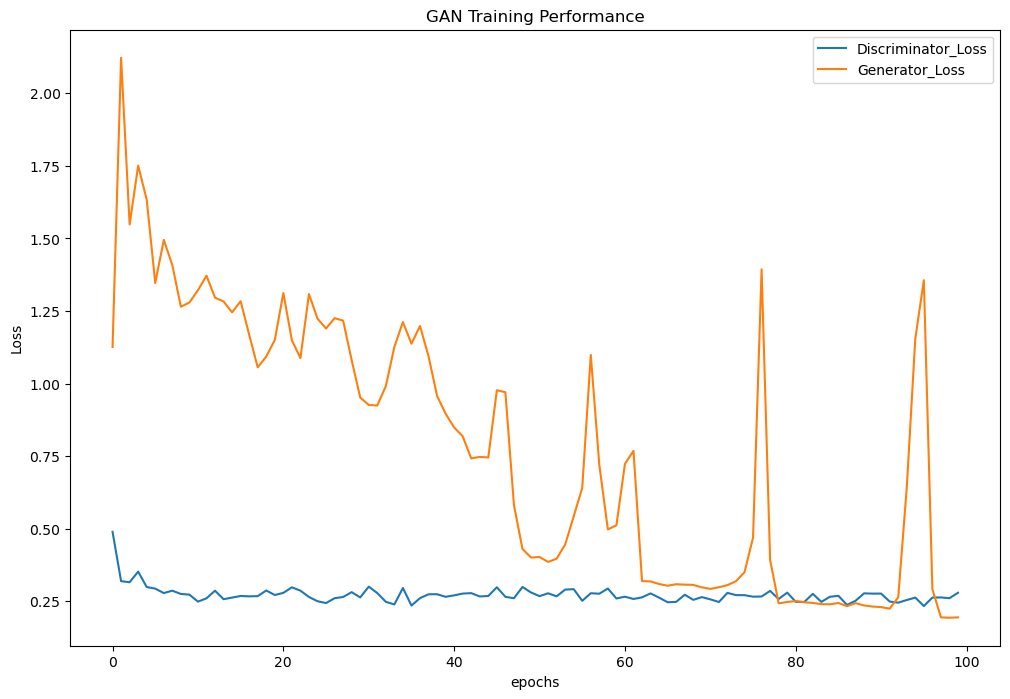

In [55]:
plt.figure(figsize=(12, 8))
plt.plot(song_gan.history.history['discriminator_loss'], label='Discriminator_Loss')
plt.plot(song_gan.history.history['generator_loss'], label='Generator_Loss')
plt.title('GAN Training Performance')

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [95]:
def eval_similarity(tries):
    sum = np.zeros(8)
    count = 0.0

    for i in range(tries):
        generated_examples = np.array([song_gan.generator.predict(tf.random.normal((50, 800, 1)),verbose=False)]).squeeze()
        training_examples = np.array([training_data[np.random.randint(low=0,high=6000)] for x in range(50)]).squeeze()
        generator_stats = np.zeros(8)
        training_data_stats = np.zeros(8)
        for feature in range(8):
            generator_stats[feature] = generated_examples[:, feature].mean()
            training_data_stats[feature] = training_examples[:, feature].mean()
        sum += np.square(generator_stats - training_data_stats)
        count += 1.0

    return np.sqrt(sum / count)


In [102]:
bar = eval_similarity(50)

In [104]:
bar

array([34.86244558,  0.82745677,  0.18481145,  0.65507138,  0.1847641 ,
        0.95617893,  0.18868791,  0.99666201])

- Shows the similarity between the training set and generated examples by comparing means of contained values across the dataset.
- this data above shows that our loudness set of vectors shows the biggest dis-resemblance from the test set. 